In [10]:
import pandas as pd
import os
dir_path = os.path.abspath('')
import matplotlib.pyplot as plt
from sklearn.preprocessing import Normalizer
from numpy import reshape as reshape
from tslearn.utils import to_time_series_dataset
from tslearn.clustering import TimeSeriesKMeans
import pickle

%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

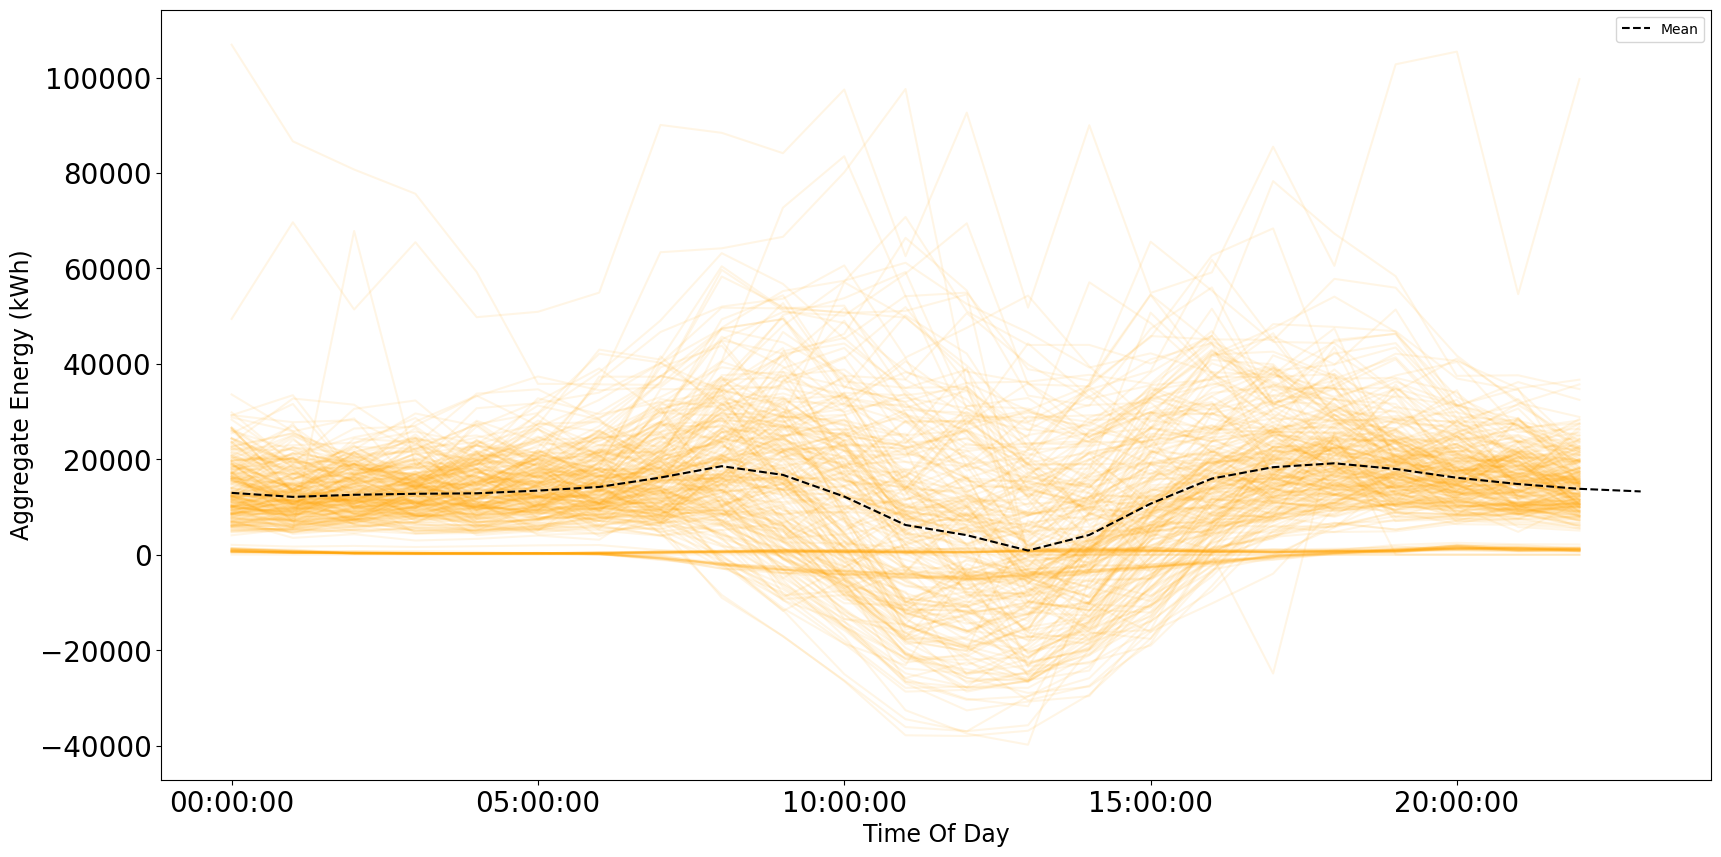

In [11]:
df2 = pd.read_csv('./data/angelos_files/clean_sql.csv', index_col=0)
fig, ax= plt.subplots(1, figsize=(20,10))
df2.drop(columns=["id"]).groupby('date').sum().T[:-1].plot(ax=ax,legend=False, alpha=0.1, color='orange', label= 'Daily Consumption', fontsize=20)
df2.drop(columns=["id"]).groupby('date').sum().mean().T.plot(ax=ax,legend=True, color='black', ls='--', label= 'Mean')
plt.xlabel('Time Of Day', fontsize='17')
plt.ylabel('Aggregate Energy (kWh)', fontsize='17')
plt.savefig('results/figures/aggregate.png', dpi=300)

In [12]:
def scale(array):
    # Very important to scale!
    sc = Normalizer(norm='l2')
    array = sc.fit_transform(array)
    return array


def df_and_np_array():
    df1 = pd.read_csv('./data/angelos_files/clean_mongo.csv', index_col=0)
    df2 = pd.read_csv('./data/angelos_files/clean_sql.csv', index_col=0)
    # df1 = pd.read_csv('./data/clean_oldmongo_small.csv', index_col=0)
    # df2 = pd.read_csv('./data/clean_sql_small.csv', index_col=0)
    df1 = df1[df1['id'] != 'BBB6179']
    df1 =df1[df1['id'] != 'BBB6169']

    all_data = pd.concat([df1,df2])
    all_data.dropna(axis=0, inplace=True)
    all_data = all_data.reset_index()

    X = all_data.copy()
    X = X.drop(columns=['id', 'date', 'index'])
    X = X.values.copy()
    return(all_data, X)

In [13]:
all_data, X = df_and_np_array()
X = scale(X)

all_data.date = pd.to_datetime(all_data.date)
all_data['month'] = all_data.date.dt.month
all_data['day'] = all_data.date.dt.day_of_week

all_data

,index,date,00:00:00,01:00:00,02:00:00,03:00:00,04:00:00,05:00:00,06:00:00,07:00:00,...,17:00:00,18:00:00,19:00:00,20:00:00,21:00:00,22:00:00,23:00:00,id,month,day
0,1,2019-05-14,0.000,0.000,0.000,0.000,0.000,0.000,0.000,7554.000,...,8347.000,8014.000,6179.000,6463.000,6140.000,6262.000,6283.000,BBB6004,5,1
1,2,2019-05-15,6301.000,6452.000,6235.000,6226.000,1728.000,1461.000,17290.000,25178.000,...,6867.000,6507.000,6049.000,5975.000,6019.000,6029.000,6348.000,BBB6004,5,2
2,3,2019-05-16,6104.000,6128.000,6094.000,5524.000,1635.000,1708.000,19002.000,21342.000,...,7374.000,6592.000,7265.000,5666.000,5619.000,5645.000,5975.000,BBB6004,5,3
3,4,2019-05-17,5835.000,5747.000,5769.000,5133.000,1472.000,1145.000,4679.000,6428.000,...,5620.000,3513.000,5934.000,5971.000,6082.000,6113.000,5959.000,BBB6004,5,4
4,5,2019-05-18,5972.000,6011.000,6055.000,6049.000,1887.000,1539.000,11367.000,19895.000,...,1276.000,3045.000,5584.000,5703.000,5838.000,5885.000,5689.000,BBB6004,5,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14796,7939,2022-06-22,9.712,11.390,8.107,6.907,7.994,9.197,6.589,7.213,...,38.461,7.228,28.863,24.884,59.442,49.330,9.836,BBB6198,6,2
14797,7940,2022-06-23,10.739,9.078,7.547,9.150,9.196,6.987,7.213,9.443,...,10.155,9.420,10.034,10.060,11.285,8.219,7.082,BBB6198,6,3
14798,7941,2022-06-24,9.651,9.317,7.542,6.660,9.435,8.530,7.225,7.468,...,8.251,7.953,7.613,8.177,9.175,10.205,8.227,BBB6198,6,4
14799,7942,2022-06-25,7.335,7.451,8.030,8.430,9.324,7.420,5.983,6.476,...,7.513,7.467,7.583,9.378,9.432,8.765,7.984,BBB6198,6,5


### clustering

In [14]:
metric = 'dtw'
n_clusters = 14
X1 = to_time_series_dataset(X)
kmeans = TimeSeriesKMeans(n_clusters=n_clusters, init='random', n_init=10, random_state=0, metric=metric, max_iter=5, metric_params={"global_constraint": "sakoe_chiba", "sakoe_chiba_radius":1})
cluster_found = kmeans.fit_predict(X1)
cluster_centers = kmeans.cluster_centers_
cluster_centers = cluster_centers.reshape(cluster_centers.shape[0], (cluster_centers.shape[1]*cluster_centers.shape[2]))

### save clustered dataset and model

In [15]:
# create dir for results
model_name = f'kmeans_{metric}_{n_clusters}'
os.mkdir(f'results/models/{model_name}')

# concat dataframes
x = pd.DataFrame(X)
y = pd.DataFrame(cluster_found, columns=["cluster"])
x_y=pd.concat([x, y], axis=1)

# save x, y
x_y.to_csv(f'results/models/{model_name}/x_y.csv', index=False, header=True)

# save y
y.to_csv(f'results/models/{model_name}/y.csv', index=False, header=True)

# save model
pickle.dump(kmeans, open(f'results/models/{model_name}/model.pkl','wb'))